# CBE 143. Spring 2020: Final Project 
## Name: Emmy Yu 
Deadline: Friday May 8th, 2020 11:59 pm

### Abstract
> I will focus on the academic journal titled Data-driven prediction of battery cycle life
before capacity degradation and the accompanying datasets on lithium-ion battery cycle life by
Severson, Attia, and Jin (2019). Severson, Attia, and Jin (2019) recently published a journal article that demonstrates their methods of generating quantitative predictions of lithium-ion battery cycle life by applying machine learning techniques to discharge voltage curves. This article comes at an appropriate time since lithium-ion batteries are already ubiquitous in mobile electronics such as smart phones and laptops, to electric vehicles due to high energy densities and long expected battery lifetimes (Gaines). Rechargeable lithium-ion batteries are of current and broad interest as the world transitions toward greater renewable energy usage, and it comes as no surprise that researchers are developing techniques to find out how many charging cycles these batteries will last.

>Severson et al. attempts a machine-learning approach to predicting battery lifetimes, utilizing a publicly-available dataset of 124 lithium iron phosphate (LFP) and graphite cells cycled under fast-charging conditions in a laboratory setting. In particular, Severson et al. opts for an elastic net regularized linear model, but in this notebook, I will be looking into Least Squares, Ridge, and Lasso Regression models. To allow for fair comparisons, the raw data provided by Severson et al. will be cleaned by removing the same measurements, and training/validation/test sets will follow
roughly the same percentage split.


#### Important 'Imports' 

In [388]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sp
import random 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV

import warnings
warnings.filterwarnings("ignore")

# Dataset 1: Lithium-ion Battery Cycle Life Before Capacity Degredation 
Publicly-available dataset from Richard Braatz: https://github.com/rdbraatz/data-driven-prediction-of-battery-cycle-life-before-capacity-degradation. 

The code in this repository is associated with the paper **Severson et al. Data-driven prediction of battery cycle life before capacity degradation. Nature Energy volume 4, pages 383–391 (2019).**
The data is available at https://data.matr.io/1/.

The dataset is divided into three “batches”, representing approximately 48 cells each. Each batch is defined by a “batch date”, or the date the tests were started. Each batch has a few irregularities, as detailed on the Github linked above.

In [2]:
#conda install h5py

In [3]:
import h5py
import pickle 

A total of 124 battery cells are used in this analysis, and it is composed of a combination of measurements taken in three separate instances: 
- Batch 1: (taken 2017-05-12) https://data.matr.io/1/projects/5c48dd2bc625d700019f3204/batches/5c86c0b5fa2ede00015ddf67
- Batch 2: (taken 2017-06-30) https://data.matr.io/1/projects/5c48dd2bc625d700019f3204/batches/5c86bf14fa2ede00015ddd83
- Batch 3: (taken 2018-04-12) 
https://data.matr.io/1/projects/5c48dd2bc625d700019f3204/batches/5c86bd64fa2ede00015ddbb3

The analysis was originally performed by Severson et al. was done in MATLAB, but the authors also provide access information in python. In the MATLAB files (.mat), this data is stored in a struct. In the python files (.pkl), this data is stored in nested dictionaries. In the cells below, using instructions found on the github link provided above, the batch records were loaded and then compiled. 

### Batch 1

In [4]:
pathToData1 = '/Users/emmy/Downloads/CBE 143 Discussions/2017-05-12_batchdata_updated_struct_errorcorrect.mat'

f = h5py.File(pathToData1)
batch = f['batch']
num_cells = batch['summary'].shape[0]
bat_dict1 = {}
for i in range(num_cells):
    cl = f[batch['cycle_life'][i,0]].value
    policy = f[batch['policy_readable'][i,0]].value.tobytes()[::2].decode()
    summary_IR = np.hstack(f[batch['summary'][i,0]]['IR'][0,:].tolist())
    summary_QC = np.hstack(f[batch['summary'][i,0]]['QCharge'][0,:].tolist())
    summary_QD = np.hstack(f[batch['summary'][i,0]]['QDischarge'][0,:].tolist())
    summary_TA = np.hstack(f[batch['summary'][i,0]]['Tavg'][0,:].tolist())
    summary_TM = np.hstack(f[batch['summary'][i,0]]['Tmin'][0,:].tolist())
    summary_TX = np.hstack(f[batch['summary'][i,0]]['Tmax'][0,:].tolist())
    summary_CT = np.hstack(f[batch['summary'][i,0]]['chargetime'][0,:].tolist())
    summary_CY = np.hstack(f[batch['summary'][i,0]]['cycle'][0,:].tolist())
    summary = {'IR': summary_IR, 'QC': summary_QC, 'QD': summary_QD, 'Tavg':
                summary_TA, 'Tmin': summary_TM, 'Tmax': summary_TX, 'chargetime': summary_CT,
                'cycle': summary_CY}
    cycles = f[batch['cycles'][i,0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = np.hstack((f[cycles['I'][j,0]].value))
        Qc = np.hstack((f[cycles['Qc'][j,0]].value))
        Qd = np.hstack((f[cycles['Qd'][j,0]].value))
        Qdlin = np.hstack((f[cycles['Qdlin'][j,0]].value))
        T = np.hstack((f[cycles['T'][j,0]].value))
        Tdlin = np.hstack((f[cycles['Tdlin'][j,0]].value))
        V = np.hstack((f[cycles['V'][j,0]].value))
        dQdV = np.hstack((f[cycles['discharge_dQdV'][j,0]].value))
        t = np.hstack((f[cycles['t'][j,0]].value))
        cd = {'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin, 'T': T, 'Tdlin': Tdlin, 'V':V, 'dQdV': dQdV, 't':t}
        cycle_dict[str(j)] = cd
        
    cell_dict = {'cycle_life': cl, 'charge_policy':policy, 'summary': summary, 'cycles': cycle_dict}
    key = 'b1c' + str(i)
    bat_dict1[key]=   cell_dict

In [5]:
with open('batch1.pkl','wb') as fp:
        pickle.dump(bat_dict1,fp)

As per K.A. Severson, P.M. Attia, et al., their dataset removes batteries that do not reach 80% capacity. Removing these batteries from Batch 1 results in a total of 41 battery measurements: 

In [232]:
batch1 = pickle.load(open(r'/Users/emmy/Downloads/CBE 143 Discussions/batch1.pkl', 'rb'))
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [7]:
numBat1 = len(batch1.keys())
numBat1

41

### Batch 2

In [8]:
pathToData2 = '/Users/emmy/Downloads/CBE 143 Discussions/2017-06-30_batchdata_updated_struct_errorcorrect.mat'

f = h5py.File(pathToData2)
batch = f['batch']
num_cells = batch['summary'].shape[0]
bat_dict2 = {}
for i in range(num_cells):
    cl = f[batch['cycle_life'][i,0]].value
    policy = f[batch['policy_readable'][i,0]].value.tobytes()[::2].decode()
    summary_IR = np.hstack(f[batch['summary'][i,0]]['IR'][0,:].tolist())
    summary_QC = np.hstack(f[batch['summary'][i,0]]['QCharge'][0,:].tolist())
    summary_QD = np.hstack(f[batch['summary'][i,0]]['QDischarge'][0,:].tolist())
    summary_TA = np.hstack(f[batch['summary'][i,0]]['Tavg'][0,:].tolist())
    summary_TM = np.hstack(f[batch['summary'][i,0]]['Tmin'][0,:].tolist())
    summary_TX = np.hstack(f[batch['summary'][i,0]]['Tmax'][0,:].tolist())
    summary_CT = np.hstack(f[batch['summary'][i,0]]['chargetime'][0,:].tolist())
    summary_CY = np.hstack(f[batch['summary'][i,0]]['cycle'][0,:].tolist())
    summary = {'IR': summary_IR, 'QC': summary_QC, 'QD': summary_QD, 'Tavg':
                summary_TA, 'Tmin': summary_TM, 'Tmax': summary_TX, 'chargetime': summary_CT,
                'cycle': summary_CY}
    cycles = f[batch['cycles'][i,0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = np.hstack((f[cycles['I'][j,0]].value))
        Qc = np.hstack((f[cycles['Qc'][j,0]].value))
        Qd = np.hstack((f[cycles['Qd'][j,0]].value))
        Qdlin = np.hstack((f[cycles['Qdlin'][j,0]].value))
        T = np.hstack((f[cycles['T'][j,0]].value))
        Tdlin = np.hstack((f[cycles['Tdlin'][j,0]].value))
        V = np.hstack((f[cycles['V'][j,0]].value))
        dQdV = np.hstack((f[cycles['discharge_dQdV'][j,0]].value))
        t = np.hstack((f[cycles['t'][j,0]].value))
        cd = {'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin, 'T': T, 'Tdlin': Tdlin, 'V':V, 'dQdV': dQdV, 't':t}
        cycle_dict[str(j)] = cd
        
    cell_dict = {'cycle_life': cl, 'charge_policy':policy, 'summary': summary, 'cycles': cycle_dict}
    key = 'b2c' + str(i)
    bat_dict2[key]=   cell_dict

In [9]:
with open('batch2.pkl','wb') as fp:
        pickle.dump(bat_dict2,fp)

In [10]:
batch2 = pickle.load(open(r'/Users/emmy/Downloads/CBE 143 Discussions/batch2.pkl','rb'))

There are four cells from Batch 1 that carried into Batch 2. The next cells removes the data from Batch 2 and puts it with the correct cell from Batch 1. This results in a total of 43 Batch 2 battery measurements:

In [11]:
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [12]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [13]:
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']
numBat2 = len(batch2.keys())
numBat2

43

### Batch 3

In [14]:
pathToData3 = '/Users/emmy/Downloads/CBE 143 Discussions/2018-04-12_batchdata_updated_struct_errorcorrect.mat'

f = h5py.File(pathToData3)
batch = f['batch']
num_cells = batch['summary'].shape[0]
bat_dict3 = {}
for i in range(num_cells):
    cl = f[batch['cycle_life'][i,0]].value
    policy = f[batch['policy_readable'][i,0]].value.tobytes()[::2].decode()
    summary_IR = np.hstack(f[batch['summary'][i,0]]['IR'][0,:].tolist())
    summary_QC = np.hstack(f[batch['summary'][i,0]]['QCharge'][0,:].tolist())
    summary_QD = np.hstack(f[batch['summary'][i,0]]['QDischarge'][0,:].tolist())
    summary_TA = np.hstack(f[batch['summary'][i,0]]['Tavg'][0,:].tolist())
    summary_TM = np.hstack(f[batch['summary'][i,0]]['Tmin'][0,:].tolist())
    summary_TX = np.hstack(f[batch['summary'][i,0]]['Tmax'][0,:].tolist())
    summary_CT = np.hstack(f[batch['summary'][i,0]]['chargetime'][0,:].tolist())
    summary_CY = np.hstack(f[batch['summary'][i,0]]['cycle'][0,:].tolist())
    summary = {'IR': summary_IR, 'QC': summary_QC, 'QD': summary_QD, 'Tavg':
                summary_TA, 'Tmin': summary_TM, 'Tmax': summary_TX, 'chargetime': summary_CT,
                'cycle': summary_CY}
    cycles = f[batch['cycles'][i,0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = np.hstack((f[cycles['I'][j,0]].value))
        Qc = np.hstack((f[cycles['Qc'][j,0]].value))
        Qd = np.hstack((f[cycles['Qd'][j,0]].value))
        Qdlin = np.hstack((f[cycles['Qdlin'][j,0]].value))
        T = np.hstack((f[cycles['T'][j,0]].value))
        Tdlin = np.hstack((f[cycles['Tdlin'][j,0]].value))
        V = np.hstack((f[cycles['V'][j,0]].value))
        dQdV = np.hstack((f[cycles['discharge_dQdV'][j,0]].value))
        t = np.hstack((f[cycles['t'][j,0]].value))
        cd = {'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin, 'T': T, 'Tdlin': Tdlin, 'V':V, 'dQdV': dQdV, 't':t}
        cycle_dict[str(j)] = cd
        
    cell_dict = {'cycle_life': cl, 'charge_policy':policy, 'summary': summary, 'cycles': cycle_dict}
    key = 'b3c' + str(i)
    bat_dict3[key]=   cell_dict

In [15]:
with open('batch3.pkl','wb') as fp:
        pickle.dump(bat_dict3,fp)

In [16]:
batch3 = pickle.load(open(r'/Users/emmy/Downloads/CBE 143 Discussions/batch3.pkl','rb'))
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

In [17]:
numBat3 = len(batch3.keys())
numBat3

40

Severson et al. attempts a machine-learning approach to predicting battery lifetimes, utilizing a publicly-available dataset of 124 lithium iron phosphate (LFP) and graphite cells cycled under fast-charging conditions in a laboratory setting. The same 124 batches will be used: 

In [18]:
numBat = numBat1 + numBat2 + numBat3
numBat

124

In [19]:
#bat_dict = {**batch1, **batch2, **batch3}

# Exploratory Data Analysis 

Since each batch of data contains a multitude of individual measurements for each battery cell, the first battery in Batch 1 will be used as an example to display. 

In [53]:
#Each key represents a battery in the batch 
print(batch1.keys())

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45'])


In [42]:
#Each battery contains several features/measurements 
batch1['b1c0'].keys()

dict_keys(['cycle_life', 'charge_policy', 'summary', 'cycles'])

For example, the battery 'b1c0' has a cycle life of 1852. The charging policy details the conditions under which the batteries were cycled. 

As per Severson et al., "the objective of this work is to optimize fast charging for lithium-ion batteries. As such, all cells in this dataset are charged with a one-step or two-step fast-charging policy. This policy has the format “C1(Q1)-C2”, in which C1 and C2 are the first and second constant-current steps, respectively, and Q1 is the state-of-charge (SOC, %) at which the currents switch. The second current step ends at 80% SOC, after which the cells charge at 1C CC-CV. The upper and lower cutoff potentials are 3.6 V and 2.0 V, respectively, which are consistent with the manufacturer’s specifications." 

In [54]:
print(batch1['b1c0']['cycle_life'])
print(batch1['b1c0']['charge_policy'])

[[1852.]]
3.6C(80%)-3.6C


For each of the 1852 cycles, there are features for Internal Resistance (IR), Charge Capacity (QC), Discharge Capacity (QD), Average Temp (Tavg), Minimum Temp (Tmin), Maximum Temp (Tmax), and charge time. 

In [233]:
battery1 = pd.DataFrame(batch1['b1c0']['summary'])
battery1.head()

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
1,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250,2.0
2,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777,3.0
3,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167,4.0
4,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442,5.0


Taking a look at some descriptive statistics on the first battery in Batch 1: 

In [119]:
battery1.describe()

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle
count,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000
mean,0.017020,1.020854,1.021118,32.007037,29.400528,36.316710,13.524102,926.000000
std,0.000806,0.057253,0.057486,1.097500,1.172854,1.155561,0.504128,534.481992
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.016737,0.990455,0.990895,31.612757,29.116013,35.844216,13.357562,463.500000
50%,0.017042,1.038362,1.038919,31.956353,29.353313,36.363941,13.425898,926.000000
75%,0.017360,1.059792,1.061009,32.386640,29.770902,36.752976,13.535407,1388.500000
max,0.018950,1.546792,1.539054,34.936976,32.662971,38.928616,19.174673,1851.000000


The discharge capacity curves for each battery in each batch are plotted below. Especially in Batch 1 and 2, there are many outlier points where the discharge capacity (QD) spiked vertically rather than decreasing continuously over each cycle. 

Text(0, 0.5, 'Discharge Capacity (Ah)')

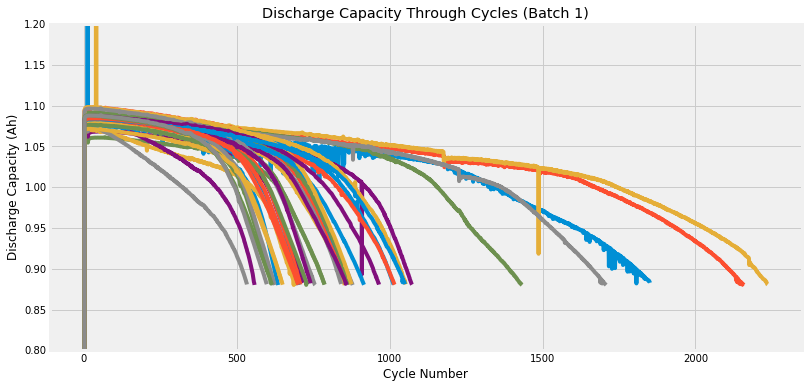

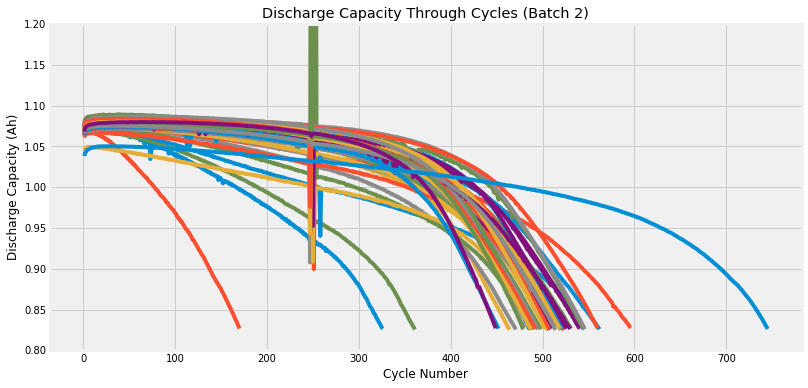

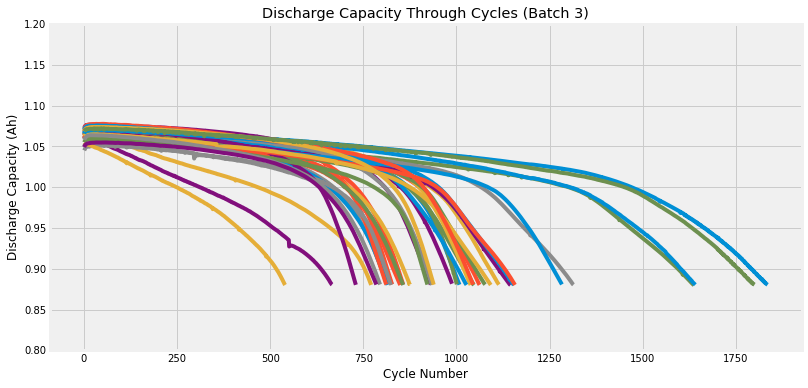

In [62]:
plt.subplots(1,1, figsize=(12,6))
for i in batch1.keys():
    plt.plot(batch1[i]['summary']['cycle'], batch1[i]['summary']['QD'])
plt.ylim(0.8,1.2)
plt.title('Discharge Capacity Through Cycles (Batch 1)')
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

plt.subplots(1,1, figsize=(12,6))
for i in batch2.keys():
    plt.plot(batch2[i]['summary']['cycle'], batch2[i]['summary']['QD'])
plt.ylim(0.8,1.2)
plt.title('Discharge Capacity Through Cycles (Batch 2)')
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

plt.subplots(1,1, figsize=(12,6))
for i in batch3.keys():
    plt.plot(batch3[i]['summary']['cycle'], batch3[i]['summary']['QD'])
plt.ylim(0.8,1.2)
plt.title('Discharge Capacity Through Cycles (Batch 3)')
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

From these discharge capacity plots above, differences can be seen between each batch of batteries. Note the scale of the x-axis for the number of cycles is much larger for Batch 1 and Batch 3. While in Batch 1 and in Batch 3, the majority of the batteries had a cycle life of around 500-1000, the cycle life in Batch 2 was lower, with the majority of the batteries at around 450-600. 

To further highlight the differences between Batch 1/3 to Batch 2, plots are generated below of all the features provided in the "summary" key. To more clearly visualize trends, only the first battery from each batch are graphed below: 

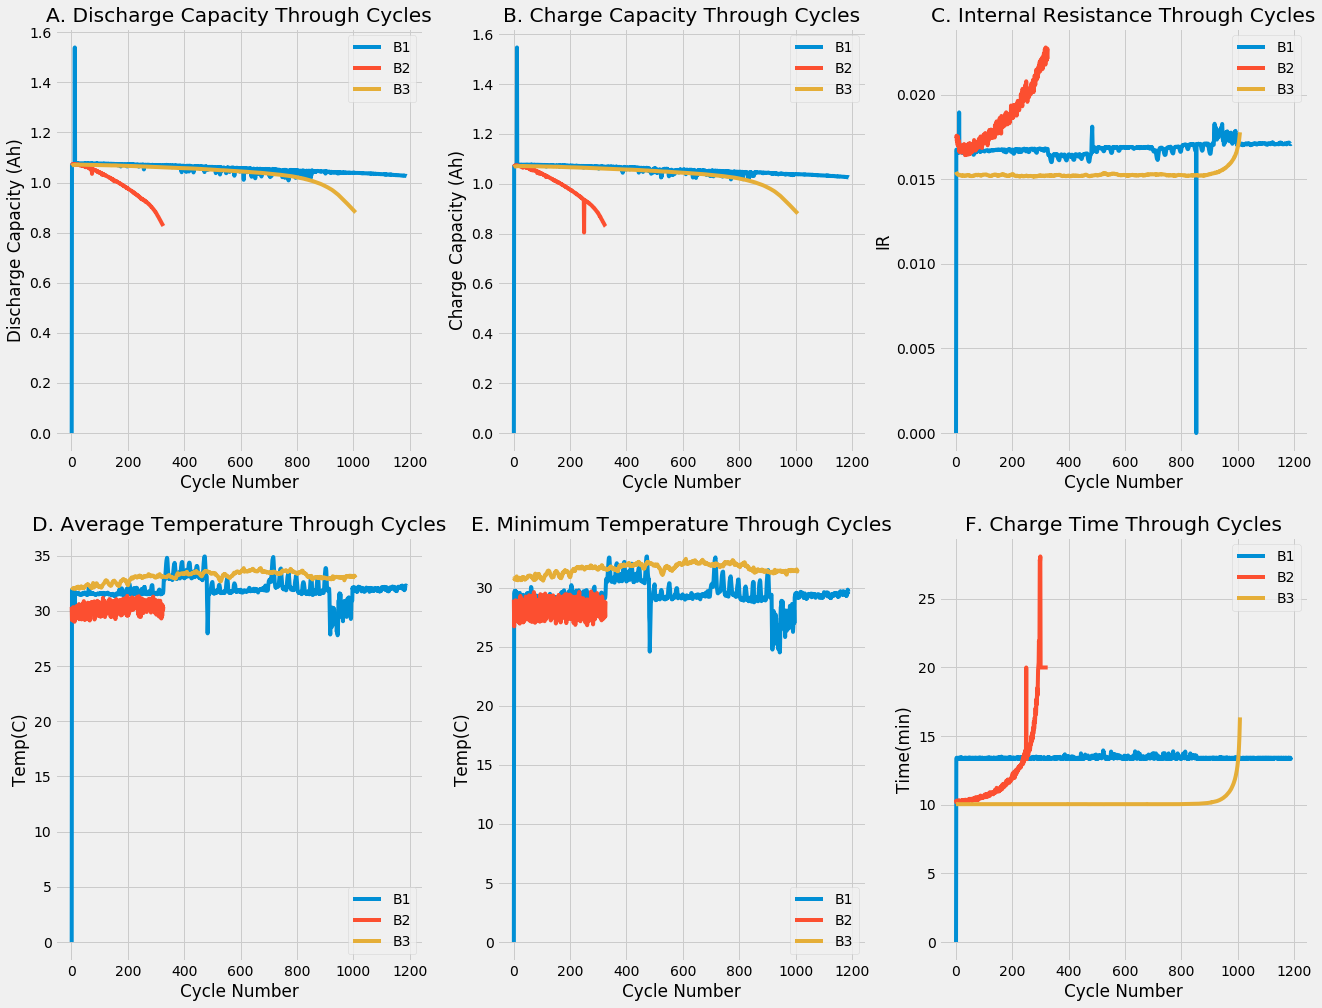

In [766]:
fig, axes= plt.subplots(2,3, figsize=(20,16))
axes = axes.flatten()
axes[0].plot(batch1['b1c0']['summary']['cycle'], batch1['b1c0']['summary']['QD'], label='B1')
axes[0].plot(batch2['b2c0']['summary']['cycle'], batch2['b2c0']['summary']['QD'], label='B2')
axes[0].plot(batch3['b3c0']['summary']['cycle'], batch3['b3c0']['summary']['QD'], label='B3')
axes[0].set(title='A. Discharge Capacity Through Cycles', xlabel='Cycle Number', ylabel='Discharge Capacity (Ah)')
axes[0].legend()

axes[1].plot(batch1['b1c0']['summary']['cycle'], batch1['b1c0']['summary']['QC'], label='B1')
axes[1].plot(batch2['b2c0']['summary']['cycle'], batch2['b2c0']['summary']['QC'], label='B2')
axes[1].plot(batch3['b3c0']['summary']['cycle'], batch3['b3c0']['summary']['QD'], label='B3')
axes[1].set(title='B. Charge Capacity Through Cycles', xlabel='Cycle Number', ylabel='Charge Capacity (Ah)')
axes[1].legend()

axes[2].plot(batch1['b1c0']['summary']['cycle'], batch1['b1c0']['summary']['IR'], label='B1')
axes[2].plot(batch2['b2c0']['summary']['cycle'], batch2['b2c0']['summary']['IR'], label='B2')
axes[2].plot(batch3['b3c0']['summary']['cycle'], batch3['b3c0']['summary']['IR'], label='B3')
axes[2].set(title='C. Internal Resistance Through Cycles', xlabel='Cycle Number', ylabel='IR')
axes[2].legend()

axes[3].plot(batch1['b1c0']['summary']['cycle'], batch1['b1c0']['summary']['Tavg'], label='B1')
axes[3].plot(batch2['b2c0']['summary']['cycle'], batch2['b2c0']['summary']['Tavg'], label='B2')
axes[3].plot(batch3['b3c0']['summary']['cycle'], batch3['b3c0']['summary']['Tavg'], label='B3')
axes[3].set(title='D. Average Temperature Through Cycles', xlabel='Cycle Number', ylabel='Temp(C)')
axes[3].legend()

axes[4].plot(batch1['b1c0']['summary']['cycle'], batch1['b1c0']['summary']['Tmin'], label='B1')
axes[4].plot(batch2['b2c0']['summary']['cycle'], batch2['b2c0']['summary']['Tmin'], label='B2')
axes[4].plot(batch3['b3c0']['summary']['cycle'], batch3['b3c0']['summary']['Tmin'], label='B3')
axes[4].set(title='E. Minimum Temperature Through Cycles', xlabel='Cycle Number', ylabel='Temp(C)')
axes[4].legend()

axes[5].plot(batch1['b1c0']['summary']['cycle'], batch1['b1c0']['summary']['chargetime'], label='B1')
axes[5].plot(batch2['b2c0']['summary']['cycle'], batch2['b2c0']['summary']['chargetime'], label='B2')
axes[5].plot(batch3['b3c0']['summary']['cycle'], batch3['b3c0']['summary']['chargetime'], label='B3')
axes[5].set(title='F. Charge Time Through Cycles', xlabel='Cycle Number', ylabel='Time(min)')
axes[5].legend()

Again, the cycle life for the batteries in each batch drastically differ from each other. By looking at only the first battery in each batch, it is clear that Batch 1 has the highest cycle life, followed by Batch 3, and then finally, Batch 2. However, the trends for all the features were consistent across all the batches. For example, in the plot of Charge time Through Cycles, each of the batteries' chargetimes remained relatively constant until they reached degredation, at which point, the charge time exponentially increases over time/cycle. A similar pattern can be seen with the internal resistance. Despite the cycle number that each battery reaches, the temperature of the batteries remained relatively constant over time and from batch to batch. 

**Taking into account Batch 2 batteries that have a relatively shorter cycle life, further comparisons and modeling will be limited to the first 100 cycles. From the graphs above, this seems like a good stopping point where most batteries have yet to experience any capacity degradation, internal resistance spikes, and charge time spikes. Since the cycle numbers of each battery is an indication for the cycle life as well, truncating the number of cycles that the models will be trained on will also reduce bias.**

Next, the cycle life of the batteries will be analyzed. To aid in visualization, the cycle life will be added to a DataFrame along with the summary features: 


In [239]:
#function that compiles all the summary features from each battery, adding "id" labels and their cycle life
def all_features(batch, new_df):
    for i in batch.keys():
        df = pd.DataFrame(batch[i]['summary'])
        df['id'] = str(i)
        df['cycle_life'] = int(batch[i]['cycle_life'])
        new_df = pd.concat([new_df,df])
    return new_df

#initializing empty DataFrame with correct column labels
df1 = pd.DataFrame(columns=batch1['b1c0']['summary'].keys())
Batch1 = all_features(batch1, df1)
Batch1 = Batch1.drop(Batch1.index[0])
Batch1

,IR,QC,QD,Tavg,Tmax,Tmin,chargetime,cycle,cycle_life,id
1,0.016742,1.071042,1.070689,31.875011,35.652016,29.566130,13.341250,2.0,1190.0,b1c0
2,0.016724,1.071674,1.071900,31.931490,35.692978,29.604385,13.425777,3.0,1190.0,b1c0
3,0.016681,1.072304,1.072510,31.932603,35.680588,29.744202,13.425167,4.0,1190.0,b1c0
4,0.016662,1.072970,1.073174,31.959322,35.728691,29.644709,13.341442,5.0,1190.0,b1c0
5,0.016623,1.073491,1.073576,31.961062,35.711758,29.752932,13.340835,6.0,1190.0,b1c0
...,...,...,...,...,...,...,...,...,...,...
593,0.020337,0.887369,0.885883,33.709809,38.676792,30.059217,19.923232,594.0,599.0,b1c45
594,0.020473,0.885484,0.884301,33.727794,38.678028,30.237862,20.731932,595.0,599.0,b1c45
595,0.020493,0.884648,0.883173,33.630904,38.663055,30.104025,22.061037,596.0,599.0,b1c45
596,0.020503,0.883895,0.882425,33.715893,38.717087,30.051764,22.810185,597.0,599.0,b1c45


It is clear from the previous graphs that the measurements for the first battery of Batch 1 has some initialization noise. Taking a closer look at battery1, all features in the first cycle are 0, skewing the the trends seen in the graphs above. **Therefore, cycle 1 of battery 1 is removed from the Batch 1 dataset.** 

In [228]:
#The same process is repreated for batteries in Batch 2 and Batch 3
Batch2 = all_features(batch2, df1)
Batch3 = all_features(batch3, df1)

Next, the discharge capacity as a function of cycle life is plotted below using a random sample of different cycles from Batch 1, where the color denotes the cycle. The data has been "jittered" for clarity in visualization. In particular, it can be seen that discharge capacity decreases with increasing cycle, but that there is a weak correlation between initial capacity and lifetime.  

Text(0, 0.5, 'Cycle Life')

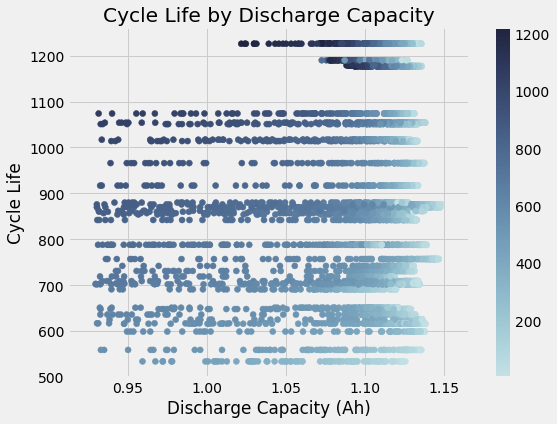

In [277]:
np.random.seed(30)
QD_jittered = Batch1.copy().sample(5000)
QD_jittered['QD'] = QD_jittered.loc[:, 'QD'] + np.random.normal(0, 0.05)

plt.subplots(1,1, figsize=(8,6))
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
points = plt.scatter(QD_jittered['QD'], QD_jittered['cycle_life'], c=QD_jittered['cycle'], cmap=cmap)
plt.colorbar(points)
plt.title('Cycle Life by Discharge Capacity')
plt.xlabel('Discharge Capacity (Ah)')
plt.ylabel('Cycle Life')

# Modeling and Analysis 

**Goals:**

As with Severson et al., the goal of this analysis is to quantitatively predict lithium-ion battery cycle life by applying machine learning techniques to discharge capacity curves. In particular, I will be applying various regression and clustering techniques a set of features to potentially predict cycle life. Accurate prediction of lifetime using early-cycle data would unlock new opportunities in battery production, use and optimization. Therefore, the training data will be limited to the first 100 cycles of each battery, at which point batteries have yet to experience any significant amount of capacity degredation. This would be an example of early prediction, and benefits to the application of a successful model would potentially allow users to estimate their battery lifetime expectancy. 

In [708]:
under100_b1 = Batch1[Batch1['cycle'] <= 100]
under100_b2 = Batch2[Batch2['cycle'] <= 100]
under100_b3 = Batch3[Batch3['cycle'] <= 100]

#This is the DataFrame that will be used in regression. 
under100_all = pd.concat([under100_b1, under100_b2, under100_b3])
X = under100_all.drop(columns=['cycle_life', 'id'])
y = under100_all[['cycle_life']]
X.head()

,IR,QC,QD,Tavg,Tmax,Tmin,chargetime,cycle
1,0.016742,1.071042,1.070689,31.875011,35.652016,29.566130,13.341250,2.0
2,0.016724,1.071674,1.071900,31.931490,35.692978,29.604385,13.425777,3.0
3,0.016681,1.072304,1.072510,31.932603,35.680588,29.744202,13.425167,4.0
4,0.016662,1.072970,1.073174,31.959322,35.728691,29.644709,13.341442,5.0
5,0.016623,1.073491,1.073576,31.961062,35.711758,29.752932,13.340835,6.0


**To perform modeling and analysis on our dataset, the dataset will be split into a training, validation, and test set:**
- Training set 70%
- Validation set 15%
- Test set 15%

In [709]:
# Train/Test Split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = .70, test_size = .30)

# Test/Validation Split
Xtest, Xvalidate, ytest, yvalidate = train_test_split(Xtest, ytest, train_size = .50, test_size = .50)

# Verifying the shape of each split. 
Xtrain.shape, Xtest.shape, Xvalidate.shape, ytrain.shape, ytest.shape, yvalidate.shape

((8651, 8), (1854, 8), (1854, 8), (8651, 1), (1854, 1), (1854, 1))

For comparison with the model used by Severson et al., the same train/test split will be created using the indices below: 


In [710]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

len(test_ind), len(train_ind), len(secondary_test_ind)

(43, 41, 40)

## Least Squares Regression Model

As a baseline model, the analysis will start with the Least Squares Linear Regression model. 

### Why Least Squares? 

OLS is an optimization method that minimizes the sum of the squared residuals. $RSS = \sum_{i=1}^n (y_{i} - \hat{y_{i}})^2$. For example, this method will draw a linear line through data points that will minimize the distance between those points and the predicted values on that line. In this case, the function is parametric since there is a linear relationship, $y = \beta_{0} + \beta_{1}x$ in which the parameters $\beta_{0}, \beta_{1}$ are known. OLS is best used when the underlying data itself has a linear association, and a line of best fit can be drawn through the data. This makes it easy and efficient to implement either by hand or through computational linear algebra. OLS is easily interpretable and understandable, in which the best prediction for an underlying linear distribution should be the line of best fit. 

However, the least squares method is very susceptible to outliers because of the squaring effect of the calculation. In addition, OLS (not surprisingly) does poorly when used to model nonlinear distributions. For example, a sinusoidal or parabolic curve cannot be well modeled by a single straight line through the data. 

In [711]:
#Functions used in analyzing this model. 
def standard_units(x):
    return (x - x.mean()) / x.std() 

def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

def correlation(x, y):
    return np.sum(standard_units(x)*standard_units(y))/len(x)

def slope(x, y):
    return correlation(x,y)*np.std(y)/np.std(x)

In [712]:
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(Xtrain, ytrain)

lin_reg_pred = lin_reg.predict(Xtrain)

In [713]:
print(f'The accuracy is: {lin_reg.score(Xtrain, ytrain)}')
print(f'The root mean squared error is: {rmse(lin_reg_pred, np.array(ytrain))}')
print(f'The correlation between actual and predicted values is: {correlation(lin_reg_pred, np.array(ytrain))}')

The accuracy is: 0.4467575154042601
The root mean squared error is: 226.4080895323268
The correlation between actual and predicted values is: 0.6683992185844176


In [714]:
def crossValidationScore(Xtrain, ytrain):
    model = LinearRegression()
    return cross_val_score(model, Xtrain, ytrain, cv=5)

crossValidationScore(Xtrain, ytrain)

array([ 0.42571446, -0.16659724,  0.42903853,  0.45073688,  0.4813501 ])

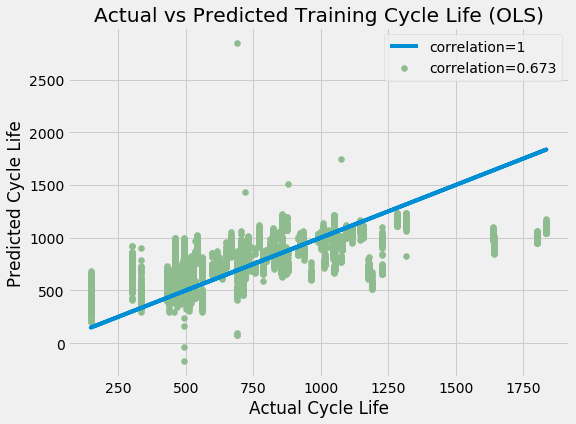

In [715]:
fig, axes= plt.subplots(1,1, figsize=(8,6))

axes.scatter(ytrain, lin_reg_pred, color='darkseagreen', label='correlation=0.673')
axes.set(title='Actual vs Predicted Training Cycle Life (OLS)', xlabel='Actual Cycle Life', ylabel='Predicted Cycle Life')
axes.plot(ytrain, ytrain, label= 'correlation=1')
axes.legend()

The plot above shows the correlation between the actual and predicted cycle life values. The blue line drawn shows the ideal 1:1 line that denotes an ideal case where the actual training values align with the predicted values. As calculated above, there is a 0.673 correlation between the actual and predicted values. From the plot above, the model seems to overpredict cycle life at lower cycle life, and underpredicts when actual cycle life is much higher. 

**The ordinary least squares is a good baseline model that has fairly good predictive capabilities. In the following parts of this notebook, the next models will explore if we can increase prediction accuracy.**

## Ridge Regression Model

### Why Ridge Regression? 

Ridge regression is a type of squared loss regression used when the number of predictors exceeds the number of observations (eg. p>n) and when the model experiences multicollinearity. Since both p>n and multicollinearity are issues when using linear least squares regression, ridge regression would be used instead. Ridge regression works by using a shrinkage estimator that essentially would produce new estimates that are "shrunk" to the population's true parameters. It is a L2 "squared" regularization that adds a penalty equal to the squared magnitude of the coefficients. A tuning parameter $\lambda$ would determine the strength of this penalty. Ridge regression is a parametric method. 

However, a disadvantage to ridge regression is the tradeoff of bias for variance. Unlike least squares, the model is biased since the coefficients are given different weights, ie. biased estimators. The constraints put on each of the estimators helps to shrink extreme variance and fluctuations; this sacrifices training accuracy for a model that is likely to generalize better. In other words, ridge regression strives to introduce enough bias that shrinks variance to make estimates closer to the true population values.

In [716]:
ridge_reg = Ridge()
ridge_reg.fit(Xtrain, ytrain)

ridge_reg_pred = ridge_reg.predict(Xtrain)

In [717]:
print(f'The accuracy is: {ridge_reg.score(Xtrain, ytrain)}')
print(f'The root mean squared error is: {rmse(ridge_reg_pred, np.array(ytrain))}')
print(f'The correlation between actual and predicted values is: {correlation(ridge_reg_pred, np.array(ytrain))}')

The accuracy is: 0.4454310080728956
The root mean squared error is: 226.6793559193948
The correlation between actual and predicted values is: 0.6674083678846237


The results from Ridge Regression remains very similar to the Linear Regression model. As part of feature engineering, it would be beneficial to take a look at multicollinearity and standardization. 

#### The Problem with Multicollinearity
The red line for y=x because values should be correlated with themselves. However, any red or blue columns show there's a strong correlation/anti-correlation that requires more investigation. For example, (unsurprisingly) it seems like 'QC' and 'QD' are highly correlated with each other, and all 3 of the temperature variables are also highly correlated with one another. 

**Regression assumes that the feature parameters used are independent from one another.**

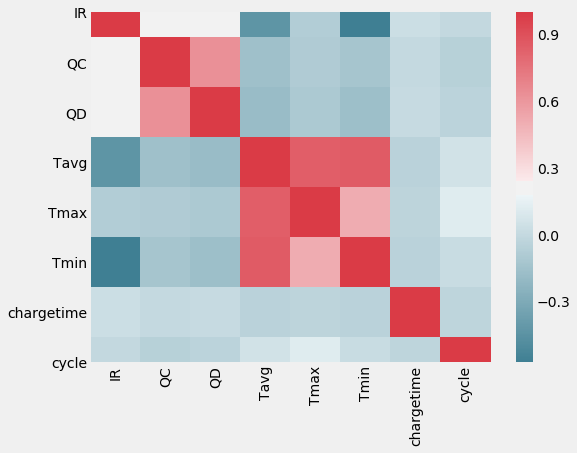

In [718]:
 plt.subplots(1,1, figsize=(8,6))
corr = Xtrain.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), \
            square=True)

In [719]:
Xtrain_dropped = Xtrain.drop(columns=['Tmax', 'QD', 'Tmin'])

ridge_reg_multi.fit(Xtrain_dropped, ytrain)
ridge_reg_pred_multi = ridge_reg.predict(Xtrain)

print(f'The accuracy is: {ridge_reg_multi.score(Xtrain_dropped, ytrain)}')
print(f'The root mean squared error is: {rmse(ridge_reg_pred_multi, np.array(ytrain))}')
print(f'The correlation between actual&predicted values is: {correlation(ridge_reg_pred_multi, np.array(ytrain))}')


The accuracy is: 0.054202192278944294
The root mean squared error is: 226.6793559193948
The correlation between actual&predicted values is: 0.6674083678846237


Dropping the columns with high multicollinearity actually resulted in decreased accuracy. In this case, there may not be an issue with multicollinearity and the model actually is not overfitting the training data. Instead, the model benefits from having additional features to train on. 

#### Standardizing the Training Data


In [720]:
Xtrain_standard = standard_units(Xtrain)
ytrain_standard = standard_units(ytrain)

#checking if (mean, std) = (0,1)
Xtrain_standard.describe().loc[['mean', 'std'], :]

,IR,QC,QD,Tavg,Tmax,Tmin,chargetime,cycle
mean,-4.952260e-14,5.959438e-14,2.915865e-14,-6.626678e-14,-1.941154e-14,-4.555218e-14,-1.766903e-15,-1.802332e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [721]:
ridge_reg.fit(Xtrain_standard, ytrain)
ridge_reg_pred_standard = ridge_reg.predict(Xtrain_standard)

print(f'The accuracy is: {ridge_reg.score(Xtrain_standard, ytrain)}')
print(f'The root mean squared error is: {rmse(ridge_reg_pred_standard, np.array(ytrain_standard))}')
print(f'The correlation between actual and predicted values is: {correlation(ridge_reg_pred_standard, np.array(ytrain_standard))}')

The accuracy is: 0.4467563256057109
The root mean squared error is: 793.7870530071858
The correlation between actual and predicted values is: 0.6683984754914148


Here, while the correlation remains the same after standardization, the root mean squared error increases. One possibility is that some of the features are almost constant except for a small noise-driven variation. Then, any noise would then be amplified greatly by the normalization.

## LASSO Model 

### Why LASSO? 

Lasso Regression (Least Absolute Shrinkage and Selection Operator) is similar to Ridge Regression in which it uses a shrinkage penalty as well. Instead of the L2 squared regularization, it uses the L1 regularization that takes the absolute value of the coefficient magnitudes. In this way, the model can be sparsed by giving some coefficients penalties of 0, effectively removing this estimator from the model. Lasso regression would potentially include fewer features while still solving the least squares issue of multicollinearity. Lasso regression is a parametric method. The same disadvantage of biasness mentioned above for Ridge regression also applies to the Lasso method as well. 

**In this iteration of linear regression using Lasso, a for loop has been set up to find the best alpha value:** 

In [722]:
alphas= [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
CVPerformance = np.zeros((len(alphas), 2))

for i,a in enumerate(alphas):
    lasso = Lasso(alpha=a)
    scores = cross_val_score(lasso, Xtrain, ytrain, cv=5)
    CVPerformance[i][0] = a
    CVPerformance[i][1] = scores.mean()
CVPerformance

array([[1.00000000e-05, 3.24062822e-01],
       [1.00000000e-04, 3.24191108e-01],
       [1.00000000e-03, 3.25453723e-01],
       [1.00000000e-02, 3.36989532e-01],
       [1.00000000e-01, 3.71063059e-01],
       [1.00000000e+00, 4.29601831e-01]])

In [723]:
lasso_reg = Lasso(alpha=0.00001)
lasso_reg.fit(Xtrain, ytrain)

lasso_reg_pred = lasso_reg.predict(Xtrain)

In [724]:
print(f'The accuracy is: {lasso_reg.score(Xtrain, ytrain)}')
print(f'The root mean squared error is: {rmse(lasso_reg_pred, np.array(ytrain))}')
print(f'The correlation between actual and predicted values is: {correlation(lasso_reg_pred, np.array(ytrain))}')

The accuracy is: 0.4467575136447705
The root mean squared error is: 366.12684514909677
The correlation between actual and predicted values is: 1.8874433091858864e-15


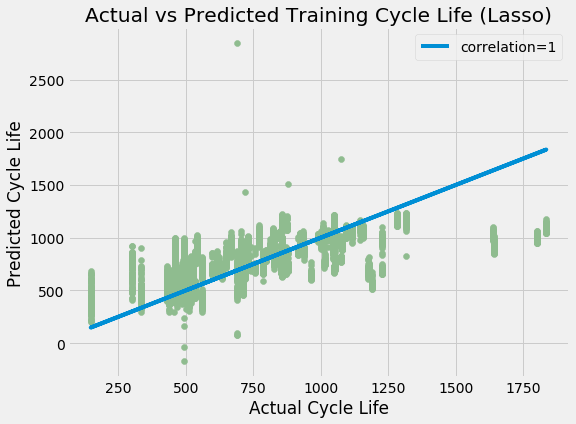

In [725]:
fig, axes= plt.subplots(1,1, figsize=(8,6))

axes.scatter(ytrain, lasso_reg_pred, color='darkseagreen')
axes.set(title='Actual vs Predicted Training Cycle Life (Lasso)', xlabel='Actual Cycle Life', ylabel='Predicted Cycle Life')
axes.plot(ytrain, ytrain, label= 'correlation=1')
axes.legend()

Even with the Lasso Regression method, there is a fair amount of difference between the predicted and actual cycle life values. Even after trying feature engineering methods such as standardization and issues with multicollinearity, and toggling with coefficient weights, there is only a weak correlation between the predicted and actual values. **It may be that this particular dataset requires a more complex model.**

## Using Cross-Validation and Power Basis Functions 

In [726]:
Xtrain_power = []
for i in range(4):
    Xtrain_power.append(np.hstack([Xtrain**(j+1) for j in range(0,i+1)]))
for i in range(4):
    print(Xtrain_power[i].shape)

(8651, 8)
(8651, 16)
(8651, 24)
(8651, 32)


In [727]:
def crossValidationScore(Xtrain, ytrain):
    model = LinearRegression()
    return np.mean(cross_val_score(model, Xtrain, ytrain, cv=5))

In [728]:
powerBasisScores = np.zeros(4)
for i, trainingX in enumerate(Xtrain_power):
    powerBasisScores[i] = crossValidationScore(trainingX, ytrain)
powerBasisScores

array([ 3.24048545e-01, -3.82376094e+01, -1.42265934e+04, -7.93125104e+04])

In [729]:
def crossValidationScoreRegularized(Xtrain, ytrain, alpha):
    model = Ridge(alpha)
    return np.mean(cross_val_score(model, Xtrain, ytrain, cv=5))

In [730]:
regularizedPowerBasisScores = np.zeros((4,4))
for i, trainingX in enumerate(Xtrain_power):
    for j, trainingAlpha in enumerate(np.linspace(1e-5, 1e-1, 4)):
        regularizedPowerBasisScores[i][j] = crossValidationScoreRegularized(trainingX, ytrain, trainingAlpha)

pd.DataFrame(regularizedPowerBasisScores)

,0,1,2,3
0,0.324089,0.344428,0.352268,0.358847
1,-34.545433,0.568881,0.535673,0.522965
2,-126.223031,0.667830,0.581629,0.515414
3,-3352.446353,-1446.995255,-878.154718,-600.028892


The same cross validation scores for model order is plotted below as a heatmap for better visualization: 

[Text(24.58, 0.5, 'Power Basis Function Order'),
 Text(0.5, 18.819999999999972, 'Regularization $\\alpha$'),
 Text(0.5, 1, 'Effect of Model Order and Regularization Weight on Performance')]

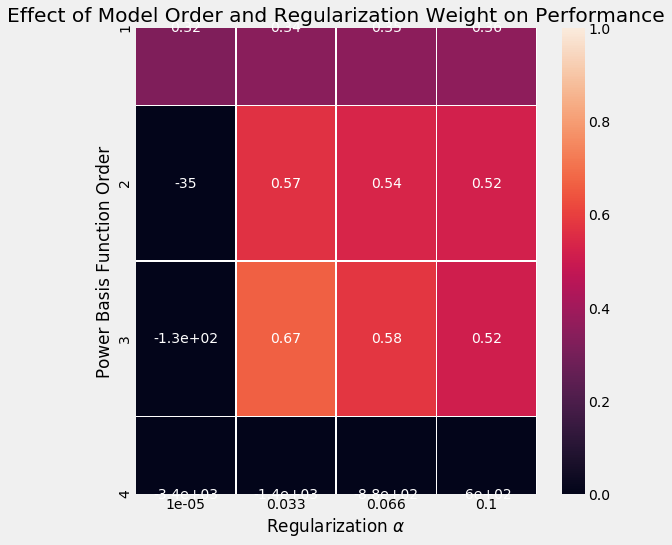

In [731]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(
    regularizedPowerBasisScores, 
    vmin=0, 
    vmax=1, 
    annot=True, 
    linewidths=0.5, 
    xticklabels=[1e-5, 3.3e-2, 6.6e-2, 1e-1], 
    yticklabels=[1, 2, 3, 4],
    ax=ax)
ax.set(
    xlabel=r'Regularization $\alpha$', 
    ylabel='Power Basis Function Order',
    title=r'Effect of Model Order and Regularization Weight on Performance')

In [732]:
model = LinearRegression()
fittedmodel = model.fit(Xtrain_power[3], ytrain)

X_power = np.hstack([Xtrain**(j+1) for j in range(4)])
predictions = fittedmodel.predict(X_power)

In [760]:
print(f'The accuracy is: {fittedmodel.score(Xtrain_power[3], ytrain)}')
print(f'The root mean squared error is: {rmse(predictions, np.array(ytrain))}')
print(f'The correlation between actual and predicted values is: {correlation(predictions, np.array(ytrain))}')

The accuracy is: 0.6862285918782337
The root mean squared error is: 170.5064694615559
The correlation between actual and predicted values is: 0.8283891650054336


### Running the Power Basis Model on the test set: 

In [761]:
Xtest_power = np.hstack([Xtest**(j+1) for j in range(4)])
test_predictions = fittedmodel.predict(Xtest_power)

In [763]:
print(f'The accuracy is: {fittedmodel.score(Xtest_power, ytest)}')
print(f'The root mean squared error is: {rmse(test_predictions, np.array(ytest))}')
print(f'The correlation between actual and predicted values is: {correlation(test_predictions, np.array(ytest))}')

The accuracy is: 0.6854457494132473
The root mean squared error is: 175.75009013966542
The correlation between actual and predicted values is: 0.8279955367301592


**Our Power Basis model has a testing accuracy of 68.5% and a correlation of 82.8%**

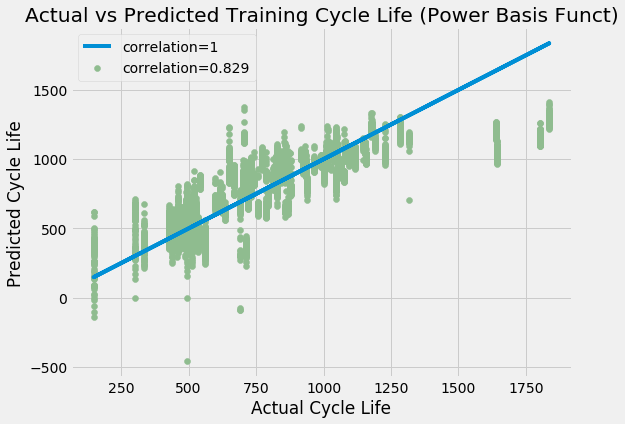

In [734]:
fig, axes= plt.subplots(1,1, figsize=(8,6))

axes.scatter(ytrain, predictions, color='darkseagreen', label='correlation=0.829')
axes.set(title='Actual vs Predicted Training Cycle Life (Power Basis Funct)', xlabel='Actual Cycle Life', ylabel='Predicted Cycle Life')
axes.plot(ytrain, ytrain, label= 'correlation=1')
axes.legend()

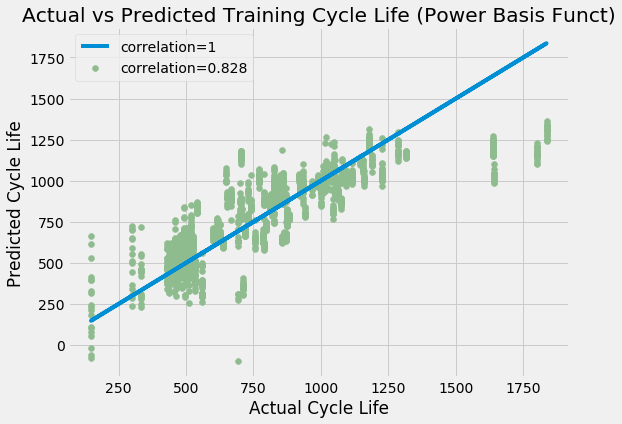

In [765]:
fig, axes= plt.subplots(1,1, figsize=(8,6))

axes.scatter(ytest, test_predictions, color='darkseagreen', label='correlation=0.828')
axes.set(title='Actual vs Predicted Training Cycle Life (Power Basis Funct)', xlabel='Actual Cycle Life', ylabel='Predicted Cycle Life')
axes.plot(ytrain, ytrain, label= 'correlation=1')
axes.legend()

Using the Power Basis Function, the correlation between predicted and actual cycle life values increased dramatically to about 0.829. While this improvement is significant, the model still seems to be underpredicting cycle life at the highest values of cycle life. 

**An explanation for this continued problem could be oversampling.**

The accuracy of a model is very much dependent on the data it is trained on. Since the training data may have more cases of batteries with lower (<1500) cycle lifes, this would lead to a model that almost exclusively predicts lower cycle lifes. Even in the power basis model, there are no predictions that are above 1500 (as seen in the plot above). A potential solution is to oversample rows with higher cycle lifes (>1500) in our training data to increase the likelihood that the model will predict a higher cycle life. Since one of the primary goals of model validation estimation of how it will perform on unseen data, oversampling correctly is critical.

## Oversampling Higher Cycle Life Values in Training Set 

A "high" cycle life is defined as having a cycle life of >1500 cycles. As seen below, the high cycle life cases only make up a small proportion of all batteries. The actual random seed that was used to create Xtrain and ytrain has an even smaller proportion of high cycle life.

In [735]:
high_cycle_life = under100_all[under100_all['cycle_life']>1500]
high_train_cycle_life = ytrain[ytrain['cycle_life']>1500]

print(f'The proportion of "high" cycle life batteries: {high_cycle_life.size/under100_all.size:.3f}')
print(f'The training set proportion of "high" cycle life batteries: {high_train_cycle_life.size/ytrain.size:.3f}')

high_cycle_life

The proportion of "high" cycle life batteries: 0.032
The training set proportion of "high" cycle life batteries: 0.032


,IR,QC,QD,Tavg,Tmax,Tmin,chargetime,cycle,cycle_life,id
0,0.015565,1.065862,1.066469,32.759826,34.233418,31.188809,11.038312,1.0,1836.0,b3c7
1,0.015536,1.066785,1.067522,32.711088,34.158512,31.156382,11.037165,2.0,1836.0,b3c7
2,0.015507,1.067980,1.068266,32.707646,34.161020,31.146513,11.037608,3.0,1836.0,b3c7
3,0.015474,1.067219,1.068769,32.686887,34.182920,31.084452,11.056270,4.0,1836.0,b3c7
4,0.015465,1.068815,1.068994,32.629166,34.096122,31.023947,11.039155,5.0,1836.0,b3c7
...,...,...,...,...,...,...,...,...,...,...
95,0.015664,1.070937,1.071107,32.716215,34.719825,30.887144,11.038408,96.0,1801.0,b3c45
96,0.015663,1.070892,1.071012,32.707957,34.774986,30.760033,11.038703,97.0,1801.0,b3c45
97,0.015654,1.070896,1.071034,32.724436,34.772697,30.741972,11.038897,98.0,1801.0,b3c45
98,0.015659,1.070837,1.070929,32.708299,34.854202,30.724630,11.040963,99.0,1801.0,b3c45


In [736]:
X = under100_all.drop(columns=['cycle_life', 'id'])
y = under100_all[['cycle_life']]

#to remind us of the exact split used in the models above
Xtrain.shape, Xtest.shape, Xvalidate.shape, ytrain.shape, ytest.shape, yvalidate.shape

((8651, 8), (1854, 8), (1854, 8), (8651, 1), (1854, 1), (1854, 1))

**To increase the number of high cycle life batteries in our new training set, all high cycle life cases from the original dataset will be used.**  

In [737]:
np.random.seed(30)
oversampled = pd.concat([under100_all.sample(8251), high_cycle_life])

Xtrain_oversampled = oversampled.drop(columns=['cycle_life', 'id'])
ytrain_oversampled = oversampled[['cycle_life']]

print(Xtrain_oversampled.shape)

(8651, 8)


In [738]:
high_clife = oversampled[oversampled['cycle_life'] >1500].size
print(f'The proportion of "high" cycle life batteries: {high_clife/under100_all.size:.3f}')

The proportion of "high" cycle life batteries: 0.055


Now, using the power basis function again: 

In [739]:
Xtrain_oversampled_power = []
for i in range(4):
    Xtrain_oversampled_power.append(np.hstack([Xtrain_oversampled**(j+1) for j in range(0,i+1)]))
for i in range(4):
    print(Xtrain_oversampled_power[i].shape)

(8651, 8)
(8651, 16)
(8651, 24)
(8651, 32)


In [740]:
model = LinearRegression()
fittedmodel_oversampled = model.fit(Xtrain_oversampled_power[3], ytrain_oversampled)

X_oversampled_power = np.hstack([Xtrain_oversampled**(j+1) for j in range(4)])
oversampled_predictions = fittedmodel_oversampled.predict(X_oversampled_power)

In [741]:
print(f'The accuracy is: {fittedmodel_oversampled.score(Xtrain_oversampled_power[3], ytrain_oversampled)}')
print(f'The root mean squared error is: {rmse(oversampled_predictions, np.array(ytrain_oversampled))}')
print(f'The correlation between actual and predicted values is: {correlation(oversampled_predictions, np.array(ytrain_oversampled))}')

The accuracy is: 0.7259317402785095
The root mean squared error is: 189.4731403200308
The correlation between actual and predicted values is: 0.852016280456695


**By oversampling, accuracy increased from 68.6% to 72.6%! Similarly, correlation between predicted and actual values increased from 82.9% to 85.2%**

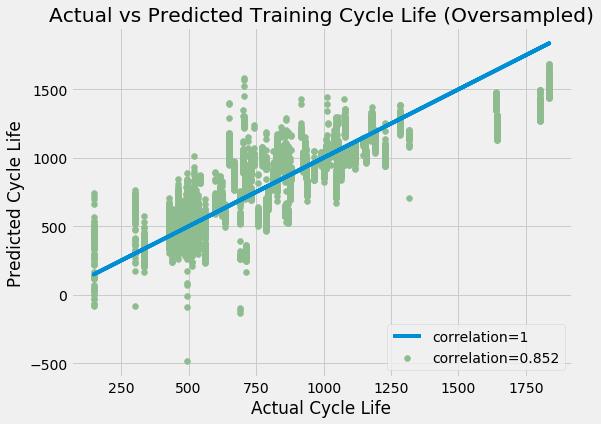

In [742]:
fig, axes= plt.subplots(1,1, figsize=(8,6))

axes.scatter(ytrain_oversampled, oversampled_predictions, color='darkseagreen', label='correlation=0.852')
axes.set(title='Actual vs Predicted Training Cycle Life (Oversampled)', xlabel='Actual Cycle Life', ylabel='Predicted Cycle Life')
axes.plot(ytrain, ytrain, label= 'correlation=1')
axes.legend()

### Adding even more high cycle life batteries to the training set: 
As expected, both accuracy and correlation increased once more high cycle life values were added to the training set! To further prove the validity of oversampling on our cycle life predictions, an even greater proportion of high cycle life values will be added to the training set. This dataset is limited to only 400/123590 total measurements in the dataset. To add even more high cycle life batteries, the same 400 cases will be duplicated in the training set. This model will use a proportion of high cycle life batteries 3 times the previous oversampling case. 

In [755]:
np.random.seed(30)
oversampled_ext = pd.concat([under100_all.sample(7051), high_cycle_life, high_cycle_life, high_cycle_life, \
                         high_cycle_life])

Xtrain_oversampled_ext = oversampled.drop(columns=['cycle_life', 'id'])
ytrain_oversampled_ext = oversampled[['cycle_life']]

Xtrain_oversampled.shape

(8651, 8)

In [756]:
high_clife_ext = oversampled_ext[oversampled_ext['cycle_life'] >1500].size
print(f'The proportion of "high" cycle life batteries: {high_clife_ext/under100_all.size:.3f}')

The proportion of "high" cycle life batteries: 0.150


In [749]:
Xtrain_oversampled_ext_power = []
for i in range(4):
    Xtrain_oversampled_ext_power.append(np.hstack([Xtrain_oversampled_ext**(j+1) for j in range(0,i+1)]))
for i in range(4):
    print(Xtrain_oversampled_ext_power[i].shape)

(8651, 8)
(8651, 16)
(8651, 24)
(8651, 32)


In [750]:
model = LinearRegression()
fittedmodel_oversampled_ext = model.fit(Xtrain_oversampled_ext_power[3], ytrain_oversampled_ext)

X_oversampled_ext_power = np.hstack([Xtrain_oversampled_ext**(j+1) for j in range(4)])
oversampled_predictions_ext = fittedmodel_oversampled_ext.predict(X_oversampled_ext_power)

In [751]:
print(f'The accuracy is: {fittedmodel_oversampled_ext.score(Xtrain_oversampled_ext_power[3], ytrain_oversampled_ext)}')
print(f'The root mean squared error is: {rmse(oversampled_predictions_ext, np.array(ytrain_oversampled_ext))}')
print(f'The correlation between actual and predicted values is: {correlation(oversampled_predictions_ext, np.array(ytrain_oversampled_ext))}')


The accuracy is: 0.8196634611004229
The root mean squared error is: 197.75126415599934
The correlation between actual and predicted values is: 0.905352945634476


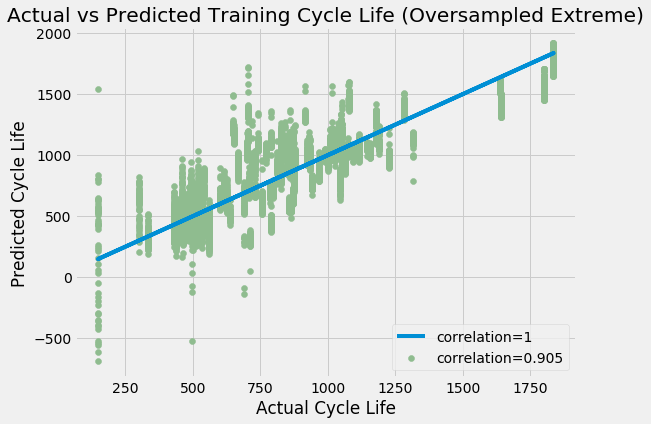

In [753]:
fig, axes= plt.subplots(1,1, figsize=(8,6))

axes.scatter(ytrain_oversampled_ext, oversampled_predictions_ext, color='darkseagreen', label='correlation=0.905')
axes.set(title='Actual vs Predicted Training Cycle Life (Oversampled Extreme)', xlabel='Actual Cycle Life', ylabel='Predicted Cycle Life')
axes.plot(ytrain, ytrain, label= 'correlation=1')
axes.legend()

**By oversampling and adding more high cycle life batteries to the training set, accuracy increased from 72.6% to 82%! Similarly, correlation between predicted and actual values increased from 85.2% to 90.5%!** 

# Modeling Conclusions 

## Evaluation of Models Used and Numerical Results
After some Exploratory Data Analysis done on the dataset, it was decided that all 3 batches of batteries would be combined to create the testing/training sets. In addition, certain batteries were eliminated from the dataset based on excessive noise (these same batteries were eliminated from the original analysis by Severson et al.) and outlier values (initial feature values = 0). A 70/15/15 train-validation-test split was performed on this dataset. 

As a baseline model, the Least Squares Regression model was used. Then, Ridge Regression and Lasso Regression methods were also applied. However, it was found that the Least Squares Regression model has the highest training correlation at 67.3%. Even after standardizing the data, dropping columns for multicollinearity, and using cross validation on coefficient weights, both Ridge and Lasso models still did not exceed the Least Squares model based on the correlation values calculated above. 

Since the correlation of 67.3% is relatively weak, the complexity of the Linear model was increased to see if correlation and accuracy increased as well. Using the Power Basis Function, cross validation methods were able to determine the optimal model complexity and alpha value. The results of this analysis can be seen in the heatmap above. Using this Power Basis technique, the training correlation between predicted and actual values increased to 82.8% (with an accuracy of 68.6%). 

Noticing a trend in the correlation graphs where the model would underpredict at high cycle life values lead to trying oversampling methods. In particular, through all the previous trials and models, there were no predictions above a cycle life of 1500. As a problem in supervised learning, since there were very few batteries in the training set that had high cycle lifes, this lead the models to tend to predict exclusively "lower" cycle life values. By oversampling (increasing the proportion of high cycle life batteries from just 3.2% to 5.5%), this improved accuracy from 68.6% to 72.6%. Similarly, correlation between predicted and actual values increased from 82.9% to 85.2%. 

To demonstrate the importance of having representative training data, a second oversampled model was run using a greater proportion of high cycle life batteries. However, limited by the available data on high cycle life batteries, the proportion of of high cycle life batteries was duplicated and added several times to the second oversampled model. This resulted in an accuracy increase from 72.6% to 82%, and correlation between predicted and actual values increased from 85.2% to 90.5%. 

## Reflecting on Limitations and Comparison with Severson et al. 

Comparing my analysis with the original publication: **Severson et al. Data-driven prediction of battery cycle life before capacity degradation. Nature Energy volume 4, pages 383–391 (2019).**

To begin, Severson et al. boasted that their "feature-based models can achieve prediction errors of 9.1% using only data from the first 100 cycles". To be able to make the same comparisons, I also used the same 124 battery measurements and first 100 cycles. After factoring in the oversampling issue, my final accuracy is 82%, which gives an error margin of 18% (not a far cry from Severson et al.'s 9.1%). 

Severson et al. opted for an elastic net regularized linear model, which utilizes both L1 and L2 regularization penalties that allows it to combine both LASSO and Ridge Regression models. To cross-validate both LI and L2 (ie. sparsing and grouping), this would require a great deal of computational power. As explained by another group (https://towardsdatascience.com/predicting-battery-lifetime-with-cnns-c5e1faeecc8f) trying analyzing the same battery dataset, "Instead of overheating our own laptops, we went with AI Platform from Google Cloud. AI Platform allowed us to run several training jobs at the same time, label them easily and monitor the process." It can be assumed that Severson et al. used software beyond what can be done in Jupyter Notebooks to create their model. 

# Potential Improvements to Model

As a regression problem, this modeling analysis sought to predict the cycle life of batteries with only data from the first 100 fast-charging cycles, at which point the batteries experienced very minimal capacity degradation. While early prediction is most useful in this scenario (consumers would want to know the expected battery lifetime), it would be interesting to see how the model would fare if trained with more cycles. 

Since problems arose in the limited prevalence of high cycle life batteries (defined as having a cycle life >1500), using a classifier instead of a regression model would also suit this analysis. Batteries could potentially be grouped into categories such as low, medium, or high cycle life. Techniques could include Clustering and Logistic Regression (binary high cycle life 1 or 0). 

While oversampling alleviates the problem with limited high cycle life batteries, it would also be ideal if more data were present for high cycle life batteries (most consumers would be interested in batteries with higher cycle life). However, with the limited data, in addition to oversampling, a bootstrapped dataset would also be a method that can be used to introduce greater variability in data. 